In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from sklearn.preprocessing import MinMaxScaler, StandardScaler

import matplotlib.pyplot as plt

from time_series_experiments import utils
from time_series_experiments import baseline
from time_series_experiments import nbeats

tf.get_logger().setLevel('ERROR')

In [4]:
seed = 0xC0FFEE
fdw = 36
fw = 12

sunspot_df = pd.read_csv('https://raw.githubusercontent.com/jbrownlee/Datasets/master/monthly-sunspots.csv')

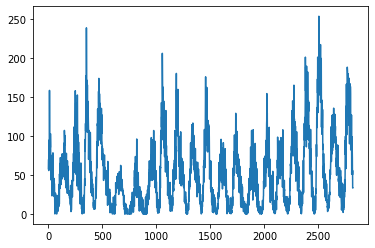

In [5]:
plt.plot(np.arange(sunspot_df.shape[0]), sunspot_df['Sunspots'].values)

In [6]:
y = sunspot_df['Sunspots'].values

x_train_idx, y_train_idx, x_test_idx, y_test_idx = utils.train_test_split_index(
    y.shape[0], fdw, fw, test_size=0.1, random_seed=seed, shuffle_train=False
)

x_train = np.expand_dims(y[x_train_idx], axis=-1)
y_train = y[y_train_idx]
x_test = np.expand_dims(y[x_test_idx], axis=-1)
y_test = y[y_test_idx]

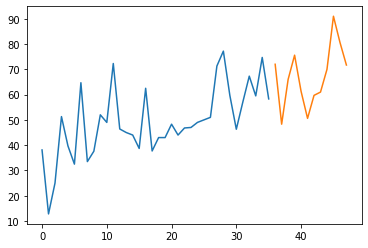

In [7]:
xplot = np.arange(fdw + fw)
plt.plot(xplot[:fdw], x_train[100])
plt.plot(xplot[-fw:], y_train[100])

In [8]:
baseline_model = baseline.LatestNaiveBaseline(fw=fw)
y_pred_baseline = baseline_model.predict(x_test)
print('RMSE', utils.rmse(y_test, y_pred_baseline))

RMSE 28.108357571067014


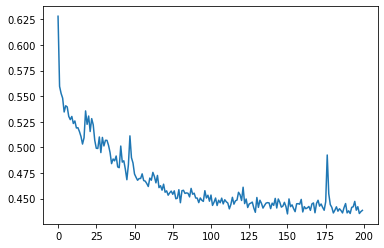

In [15]:
scaler = utils.MeanScaler()

xtr = scaler.fit_transform(x_train)
ytr = scaler.transform(y_train)

model = nbeats.NBEATS(
    fdw=fdw,
    fw=fw,
    stacks=[
        nbeats.StackDef(
            nbeats.StackTypes.NBEATS_DRESS,
            block_types=[nbeats.BlockTypes.TREND, nbeats.BlockTypes.SEASONAL],
            block_units=16,
            block_theta_units=16,
            block_layers=4,
        )
    ]
)
model.compile(loss='mae', optimizer=keras.optimizers.Adam(0.01))
history = model.fit(
    xtr, 
    ytr, 
    batch_size=8, 
    epochs=200, 
    verbose=False,
)

plot_y = np.array(history.history['loss'])
plot_x = np.arange(plot_y.shape[0])
plt.plot(plot_x, plot_y)

In [16]:
scaler = utils.MeanScaler()
xt = scaler.fit_transform(x_test)

y_pred = model.predict(xt)
y_pred = scaler.inverse_transform(y_pred)

print('RMSE', utils.rmse(y_test, y_pred)) 
print('MASE', utils.mase(y_test, y_pred, y_pred_baseline))

RMSE 20.54364019089336
MASE 0.7376043530366423


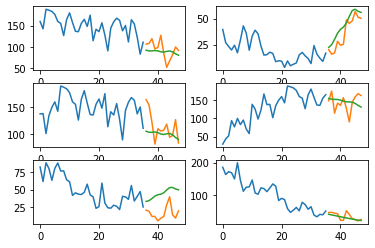

In [29]:
fig, axes = plt.subplots(3, 2)
axes = [item for sublist in axes for item in sublist]

indexes = np.random.choice(np.arange(y_pred.shape[0]), len(axes))

for i, ax in zip(indexes, axes): 
    plot_x = np.squeeze(x_test[i])
    plot_y_pred = np.squeeze(y_pred[i])
    plot_y = np.squeeze(y_test[i])
    
    plot_x_numbers = np.arange(0, plot_x.shape[0])
    plot_y_numbers = np.arange(plot_x.shape[0], plot_x.shape[0] + plot_y.shape[0])

    ax.plot(plot_x_numbers, plot_x)
    ax.plot(plot_y_numbers, plot_y)
    ax.plot(plot_y_numbers, plot_y_pred)